In [28]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import ticker
from scipy.interpolate import interp1d

from gwaxion import physics

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'serif',
    'font.size': 24,
    'font.serif': 'Computer Modern Roman'
}
matplotlib.rcParams.update(mplparams)

In [29]:
from matplotlib import cm

## Colormap

In [30]:
# create an array of BH masses

n_mass = 5000
n_chi = 1000
n_alpha = 2000

distance = 5E6 * physics.PC_SI

mbhs_array = np.linspace(1, 1E4, n_mass)
chis_array = np.linspace(1E-4, 1, n_chi)

alphas = np.linspace(0, 0.5, n_alpha)

df_list = []


dfpath = 'peak.hdf5'
if os.path.exists(dfpath):
    df_max = pd.read_hdf(dfpath, 'table', mode='r')
else:
    rows = []
    for mbh in mbhs_array:
        for chi in chis_array:
            h0s, fgws = physics.h0_scalar_brito(mbh, alphas, chi_i=chi, d=distance)
            hmax = np.nanmax(h0s)
            fmax = fgws[h0s==hmax][0]
            amax = alphas[h0s==hmax][0]
            rows.append({'mbh': mbh, 'chi': chi, 'h0': hmax, 'fgw': fmax, 'alpha': amax})
    df_max = pd.DataFrame(rows)
    df_max.to_hdf('peak.hdf5', 'table', mode='w')

In [31]:
print df_max.head()
print df_max.tail()

     alpha       chi        fgw            h0  mbh
0  0.00025  0.000100  16.164330 -2.084442e-49  1.0
1  0.00025  0.001101  16.164334  2.324040e-50  1.0
2  0.00050  0.002102  32.328668  2.983916e-48  1.0
3  0.00075  0.003103  48.493001  5.114043e-47  1.0
4  0.00075  0.004104  48.493038  5.568913e-46  1.0
            alpha       chi       fgw            h0      mbh
4999995  0.325163  0.995996  2.133077  2.110833e-22  10000.0
4999996  0.325913  0.996997  2.138113  2.135254e-22  10000.0
4999997  0.326913  0.997998  2.144597  2.159968e-22  10000.0
4999998  0.327914  0.998999  2.151085  2.184978e-22  10000.0
4999999  0.328664  1.000000  2.156135  2.210290e-22  10000.0


In [32]:
h0_bound = df_max[(df_max['mbh']>10) & (df_max['mbh']<1E3)]['h0']
print h0_bound.min()
print h0_bound.max()

-2.082565311167164e-46
2.2083002202496464e-23


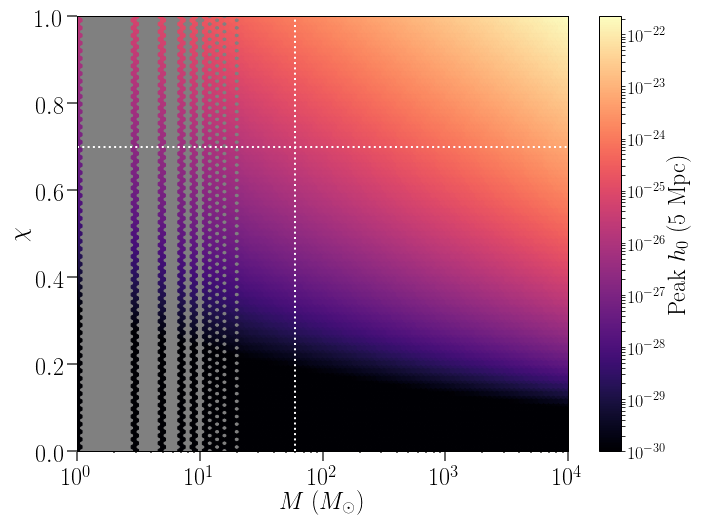

In [43]:
# colormap for peak h0 vs chi vs M

h0s = df_max['h0']
hmax_ma = np.ma.masked_array(h0s, mask=(h0s<=0)|(np.isnan(h0s)))

hmin, hmax = 1E-30, hmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=hmin, vmax=hmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_max['mbh'], df_max['chi'], C=hmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $h_0$ (5 Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(1, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_h0max.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()


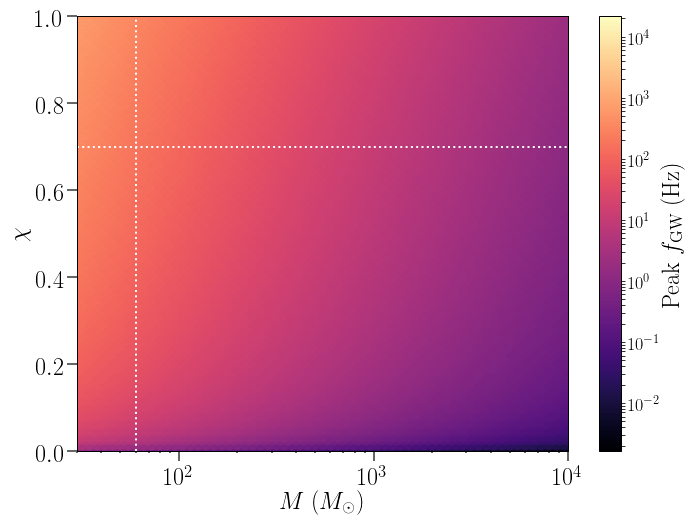

In [34]:
# colormap for peak fgw vs chi vs M

fs = df_max['fgw']
fmax_ma = np.ma.masked_array(fs, mask=(fs<=0)|(np.isnan(fs)))

fmin, fmax = fmax_ma.min(), fmax_ma.max()
norm = matplotlib.colors.LogNorm(vmin=fmin, vmax=fmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(df_max['mbh'], df_max['chi'], C=fmax_ma, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'Peak $f_{\rm GW}$ (Hz)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_fmax.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

## Range

The range is the source distance for which the peak amplitude at Earth is equal to our "minimum detectable" one:

$d_{\rm max} = \frac{h^{\rm max}_0}{h^{95}_0} d_{\rm ref} $ and $h^{95}_0(f) = h^{95}_{\rm ref} \sqrt{\frac{S_{\rm ref}}{S(f)}} \sqrt{\frac{T_{\rm ref}}{T}}$

In [35]:
# From Lilli: 95% detection efficiency h0 is 4.7e-26 at 201.2 Hz and an ASD of 4E-24 Sqrt[Hz], for T=80 days

h95ref = 4.7E-26
f95ref = 201.2
asd95ref = 4E-24

from lal import DAYSID_SI
Tref = 80*DAYSID_SI

print "Reference values:"
print "\tDistance: %.1e PC" % (distance/physics.PC_SI)
print "\tObservation time: %.1e" % (Tref / DAYSID_SI)
print "\th95: %.1e" % h95ref
print "\tASD: %.1e" % asd95ref

def horizon(h0, f, T=Tref, href=h95ref, asdref=asd95ref, Tref=Tref, psd=None, asd=None, dref=distance):
    asd = asd if asd is not None else np.array([psd(freq)**0.5 for freq in np.array(f)])
    h95 = href * (asdref/asd) * (Tref/T)**0.5
    return h0 * dref / h95
    

Reference values:
	Distance: 5.0e+06 PC
	Observation time: 8.0e+01
	h95: 4.7e-26
	ASD: 4.0e-24


### aLIGO design

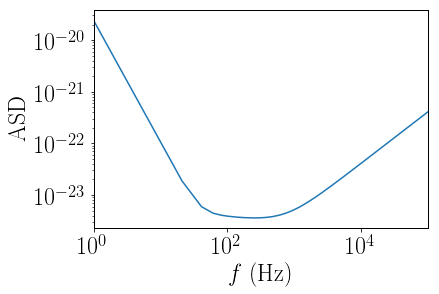

In [36]:
from lalsimulation import SimNoisePSDaLIGOZeroDetHighPower

flow = 1
fhig = 1E5
freqs = np.linspace(flow, fhig, 5000)

psd = np.array([SimNoisePSDaLIGOZeroDetHighPower(f) for f in freqs])
asd = psd**0.5

psd_interp = interp1d(freqs, psd)

fig, ax = plt.subplots(1)
ax.plot(freqs, asd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(flow, fhig)
ax.set_xlabel(r'$f$ (Hz)')
ax.set_ylabel(r'ASD')
plt.show(fig)

In [37]:
dfm = df_max[(df_max['h0']>0) & (~np.isnan(df_max['h0']) & (df_max['fgw']>0))].copy()

dfm['dmax_design_flat'] = horizon(dfm['h0'], dfm['fgw'], psd=SimNoisePSDaLIGOZeroDetHighPower)

print dfm['dmax_design_flat'].min()
print dfm['dmax_design_flat'].max()

0.627586817523294
6.691832117405732e+29


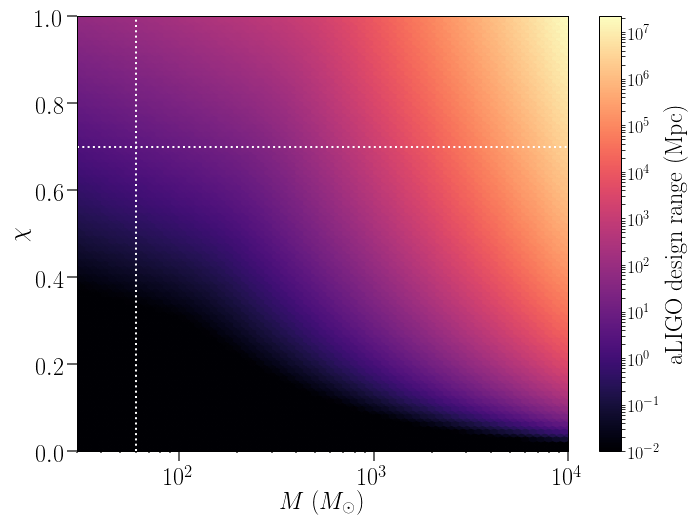

In [38]:
# colormap for peak h0 vs chi vs M

from matplotlib import ticker

#d = np.ma.masked_array(dfm['dmax_design'], dfm['dmax_design']<1E-3)
d = dfm['dmax_design_flat'] / (1E6 * physics.PC_SI)
dmin, dmax = 1E-2, d.max()
norm = matplotlib.colors.LogNorm(vmin=dmin, vmax=dmax)

fig, ax = plt.subplots(1, figsize=(11,8))

# plot contours
cm = ax.hexbin(dfm['mbh'], dfm['chi'], C=d, cmap='magma', norm=norm,  xscale='log')

# plot vertical line at 60 Msun
ax.axvline(60, c='w', ls=':', lw=2)
ax.axhline(0.7, c='w', ls=':', lw=2)

# add colorbar
#b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range (Mpc)')#, ticks=cb_ticks)
cb.ax.tick_params(labelsize=18) 

plt.ylabel(r'$\chi$')
plt.xlabel(r'$M$ $(M_\odot)$')
ax.patch.set_facecolor("grey")

plt.xlim(30, 1E4)
plt.ylim(0, 1)

ax.tick_params(axis='both', color='0.4', which='both', width=2)
ax.tick_params(axis='both', length=10)

cm.set_rasterized(True)

fig.savefig('cmap_chi_mbh_range-design_flat.pdf', bbox_inches='tight', dpi=400)

plt.show()
plt.close()

In [39]:
# check redshift at horizon
import cosmolopy.distance as cd
cosmo = {'omega_M_0':0.308, 'omega_lambda_0':0.692, 'omega_k_0':0.0, 'h':0.678}

z = 10
print z
print '%.2e' % cd.luminosity_distance(z, **cosmo)

10
1.06e+05


### 3G detectors

In [40]:
# # load Voyager ASD
# vals = np.loadtxt('noise_curves_T1500293-v10/voyager.txt')
# freqs, asd_voy_array = vals[:,0], vals[:,1]

# # create interpolant
# asdv = interp1d(freqs, asd_voy_array)

# fmin, fmax = freqs.min(), freqs.max()

# asd = asdv(freqs)

# fig, ax = plt.subplots(1)
# ax.plot(freqs, asd)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(fmin, fmax)
# ax.set_xlabel(r'$f$ (Hz)')
# ax.set_ylabel(r'ASD')
# plt.show(fig)

# print fmin, fmax

In [41]:
# # remove freqs outside interp range
# dfmv = dfm[(dfm['fgw']>fmin) & (dfm['fgw']<fmax)].copy()
# dfmv['dmax_voyager'] = horizon(dfmv['h0'], dfmv['fgw'], asd=asdv(dfmv['fgw'].values))

# print dfmv['dmax_voyager'].min()
# print dfmv['dmax_voyager'].max()

In [42]:
# # colormap for peak h0 vs chi vs M

# from matplotlib import ticker

# #d = np.ma.masked_array(dfm['dmax_design'], dfm['dmax_design']<1E-3)
# d = dfmv['dmax_voyager'] / (1E6 * physics.PC_SI)
# dmin, dmax = 1E-2, d.max()
# norm = matplotlib.colors.LogNorm(vmin=dmin, vmax=dmax)

# fig, ax = plt.subplots(1, figsize=(11,8))

# # plot contours
# cm = ax.hexbin(dfmv['mbh'], dfmv['chi'], C=d, cmap='magma', norm=norm,  xscale='log')

# # plot vertical line at 60 Msun
# ax.axvline(60, c='w', ls=':', lw=2)
# ax.axhline(0.7, c='w', ls=':', lw=2)

# # add colorbar
# #b_ticks = np.logspace(hmin, hmax, 7) # np.ceil(np.log10(h0s_ma[~np.isnan(h0s_ma)].max())), 7)
# cb = plt.colorbar(cm, norm=norm, label=r'aLIGO design range (Mpc)')#, ticks=cb_ticks)
# cb.ax.tick_params(labelsize=18) 

# plt.ylabel(r'$\chi$')
# plt.xlabel(r'$M$ $(M_\odot)$')
# ax.patch.set_facecolor("grey")

# plt.xlim(10, 1E3)
# plt.ylim(0, 1)

# ax.tick_params(axis='both', color='0.4', which='both', width=2)
# ax.tick_params(axis='both', length=10)

# cm.set_rasterized(True)

# #fig.savefig('cmap_chi_mbh_h0max.pdf', bbox_inches='tight', dpi=400)

# plt.show()
# plt.close()